In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
cd /content/drive/MyDrive/Colab Notebooks/github/PBL

/content/drive/MyDrive/Colab Notebooks/github/PBL


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1 [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] - Train Loss: 1.9912, Train Acc: 0.3068
Validation Loss: 2.7645, Validation Acc: 0.4404
Epoch 2 [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] - Train Loss: 1.5241, Train Acc: 0.4536
Validation Loss: 14.3402, Validation Acc: 0.4754
Epoch 3 [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] - Train Loss: 1.2637, Train Acc: 0.5493
Validation Loss: 2.2446, Validation Acc: 0.6088
Epoch 4 [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] - Train Loss: 1.0834, Train Acc: 0.6146
Validation Loss: 0.9977, Validation Acc: 0.6519
Epoch 5 [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] - Train Loss: 0.9495, Train Acc: 0.6669
Validation Loss: 13.9199, Validation Acc: 0.6490
Epoch 6 [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] - Train Loss: 0.8683, Train Acc: 0.6965
Validation Loss: 2.9821, Validation Acc: 0.7032
Epoch 7 [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] - Train Loss: 0.8058, Train Acc: 0.7184
Validation Loss: 1.819

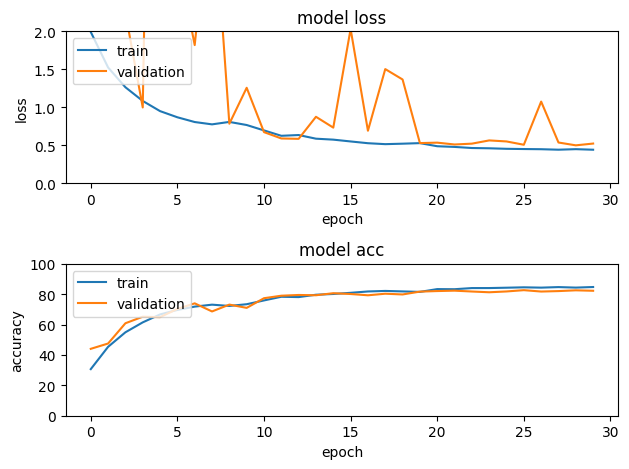

In [5]:
# for CIFAR-10, CIFAR-100

import numpy as np
import matplotlib.pyplot as plt
import model_loader

import torch
import torch.nn as nn

from torchvision import datasets, transforms

from torch.utils.data.sampler import SubsetRandomSampler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_epochs = 30
batch_size = 64

# augment *padding *HorizontalFlip
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Call CIFAR datasets
train_dataset = datasets.CIFAR10('./train', train=True, transform=transform_train, download=True)
val_dataset = datasets.CIFAR10('./train', train=True, transform=transform_test, download=True)
test_dataset = datasets.CIFAR10('./test', train=False, transform=transform_test, download=True)

# Split train datasets for validation datasets
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))
train_idx, val_idx = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_idx)
np.random.shuffle(indices)
train_sampler = SubsetRandomSampler(train_idx)

# Create DataLoader (split by batch size)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

cnt_progress = len(train_loader) // 30

model_name = 'efficientnet_b6'
model = model_loader.load(model_name, num_class=10).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
loss_func = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)

best_val_loss = float('Inf')
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for epoch in range(num_epochs):
    model.train()
    total_train_acc = 0
    total_train_loss = 0
    for cnt, (images_, labels_) in enumerate(train_loader):
        images = images_.to(device)
        labels = labels_.to(device)

        predict = model(images)
        loss = loss_func(predict, labels.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_acc += (predict.argmax(1) == labels).float().mean().item()
        total_train_loss += loss.item()
        # progress bar 구현
        if cnt % cnt_progress == 0:
            print(f'\rEpoch {epoch + 1} [', end='')
            for prog in range(cnt // cnt_progress):
                print('■', end='')
            for prog in range((len(train_loader) - cnt) // cnt_progress):
                print('□', end='')
            print(']', end='')

    total_train_loss /= len(train_loader)
    total_train_acc /= len(train_loader)
    train_loss.append(total_train_loss)
    train_acc.append(total_train_acc)
    print(f' - Train Loss: {total_train_loss:.4f}, Train Acc: {total_train_acc:.4f}')

    model.eval()  # 모델을 평가 모드로 설정
    total_val_acc = 0
    total_val_loss = 0
    with torch.no_grad():
        for images_, labels_ in val_loader:
            images = images_.to(device)
            labels = labels_.to(device)

            predict = model(images)
            acc = (predict.argmax(1) == labels).float().mean().item()
            loss = loss_func(predict, labels.long())
            total_val_acc += acc
            total_val_loss += loss.item()

        total_val_loss /= len(val_loader)
        total_val_acc /= len(val_loader)

    val_loss.append(total_val_loss)
    val_acc.append(total_val_acc)
    print(f'Validation Loss: {total_val_loss:.4f}, Validation Acc: {total_val_acc:.4f}')

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), 'best_model.pt')

    scheduler.step()

model.load_state_dict(torch.load('best_model.pt'))
model.eval()

total_test_acc = 0
total_test_loss = 0
with torch.no_grad():
    for images_, labels_ in test_loader:
        images = images_.to(device)
        labels = labels_.to(device)

        predict = model(images)

        acc = (predict.argmax(1) == labels).float().mean().item()
        loss = loss_func(predict, labels.long())

        total_test_acc += acc
        total_test_loss += loss.item()

    total_test_loss /= len(test_loader)
    total_test_acc /= len(test_loader)

print(f'Test Loss: {total_test_loss:.4f}, Test Acc: {total_test_acc:.4f}')

# plot Loss Graph
plt.subplot(2, 1, 1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 2)
plt.legend(['train', 'validation'], loc='upper left')
# plot Acc Graph
plt.subplot(2, 1, 2)
plt.plot(np.array(train_acc) * 100)
plt.plot(np.array(val_acc) * 100)
plt.title('model acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 100)
plt.legend(['train', 'validation'], loc='upper left')

plt.tight_layout()
plt.savefig(f'graphs/{model_name}_residual.png')

model = model.to("cpu")
torch.cuda.empty_cache()